In [1]:
import os
from collections import defaultdict
from datetime import datetime

from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib 

matplotlib.rcParams.update({'font.size': 15})
%matplotlib inline

import plotly
import plotly.graph_objs as pgo

from nxplot_3d import get_trace_nodes_3D_legend
from nxplot_3d import get_trace_edges_3D
from nxplot_3d import plot_3D

from export_import import export_data
from export_import import read_data

from csv_to_network import get_graph

In [2]:
path= '../data/dynamic/'
file_names =  sorted(os.listdir(path), key=lambda x: datetime.strptime(x, '%Y-%m.csv'))
data = pd.DataFrame(columns=['package', 'requirement', 'time'])

for i, fname in enumerate(file_names):
    dframe_load = pd.read_csv(path+ fname, sep='|', keep_default_na=False)
    dframe_load = dframe_load.assign(time=[fname[:-4] for _ in range(len(dframe_load))])
    data = pd.concat([data, dframe_load], ignore_index=True)
    

In [3]:
class TDiGraph(nx.DiGraph):
    def __init__(self, all_edges:pd.DataFrame):
        self.t = 0
        
        self.all_edges = all_edges
        self.all_nodes = all_edges.drop_duplicates(subset=self.all_edges.keys()[0], ignore_index=True)
        
        self.time_edges = self.all_edges['time']
        self.time_nodes = self.all_nodes['time']
        self.time_steps = sorted(list(set(self.time_nodes)), key=lambda x: datetime.strptime(x, '%Y-%m'))
        
        super(TDiGraph, self).__init__()
    
    def __str__(self):
        return f'TDiGraph with {self.number_of_nodes()} nodes and {self.number_of_edges()} edges at time {self.t}'
    
    def __repr__(self):
        return 'time extention of networkx.classes.digraph.DiGraph'
        
    def forward(self):
        if self.t <= len(self.time_steps):
            self.add_edges_from(zip(self.all_edges[self.time_edges==self.time_steps[self.t]].iloc[:,0],\
                                       self.all_edges[self.time_edges==self.time_steps[self.t]].iloc[:,1]))
            self.remove_nodes_from([''])
            self.t += 1
        else:
            raise GeneratorError(f'Max t={len(self.time_steps) + 1} reached')
            
    
    def backward(self):
        if self.t != 0:
            self.remove_edges_from(zip(self.all_edges[self.time_edges==self.time_steps[self.t]].iloc[:,0],\
                                       self.all_edges[self.time_edges==self.time_steps[self.t]].iloc[:,1]))
            self.remove_nodes_from([''])
            self.t -= 1
        else:
            raise GeneratorError('Time t=0 reached')


In [4]:
def tdg_draw(TDG):
    if TDG.time_steps[TDG.t][4:] == '-1':
        max_deg = max(TDG.degree(), key=lambda x: x[1])[1]
        if max_deg == 0:
            max_deg = 1
        posDG3D = nx.spring_layout(TDG, dim=3, k=1/np.sqrt(TDG.number_of_nodes())*10)
        partition = {node: 1 for node in TDG.nodes()}
        cmap = cm.get_cmap('Reds', max(partition.values()) + 1)
        export_data(TDG, posDG3D, partition, cmap, path='../nodes_edges/dynamic/', step=TDG.t, max_deg=max_deg)
        G, d_hoverinfo, d_nodecolors, d_nodesize, posG3D = read_data(f'../nodes_edges/dynamic/nodes_{TDG.t}.csv',
                                                                     f'../nodes_edges/dynamic/edges_{TDG.t}.csv')
        node_trace = get_trace_nodes_3D_legend(posG3D, d_hoverinfo, d_nodecolors, d_nodesize)
        edge_trace = get_trace_edges_3D(G, posG3D, color = '#C7C7C7', opac = 0.4, linewidth=0.5)
        data = [*node_trace, edge_trace]
        plot_3D(data, path='../plots/dynamic/', fname = str(TDG.time_steps[TDG.t]), scheme='dark')

def get_growth(TDG, k_i_t:dict):
    add_degrees = TDG.in_degree
    k_i_t.update({node: [*k_i_t[node], int(deg)] for node, deg in add_degrees})
    return k_i_t

# Growth Exponent

In [5]:
TDG = TDiGraph(data)
k_i_t = {node: [] for node in TDG.all_nodes.iloc[:,0]}
for i in range(len(TDG.time_steps)):
    TDG.forward()
    get_growth(TDG, k_i_t)

In [6]:
k_i_t = sorted(list(k_i_t.items()), key=lambda x: max(x[1]), reverse=True)

/home/miksa/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0, 0.5, '$k^{in}_i(t)$')

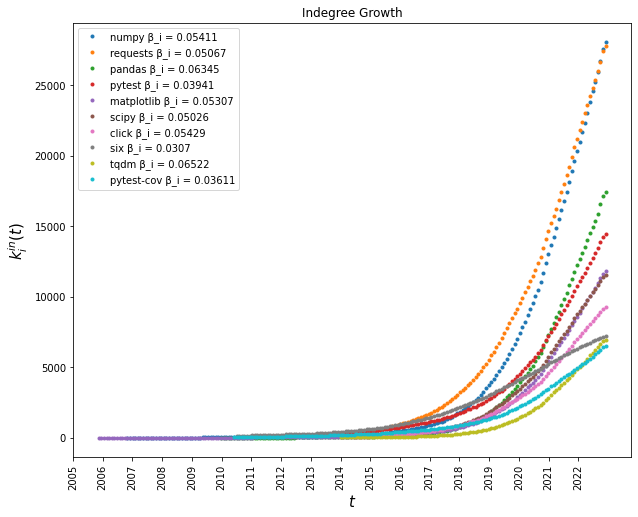

In [27]:
def fit_lin(x, β, B):
    return β * x + B 

time_steps = len(TDG.time_steps)
years = sorted(list(set([date[:4] for date in TDG.time_steps])), key=lambda x: datetime.strptime(x, '%Y'))
fig, ax = plt.subplots(1, 1, figsize=[10, 8])
cmap = cm.get_cmap('tab10').colors
j=0
β_i = {}

for node, k_i in [k_i_t[i] for i in range(len(k_i_t)) if max(k_i_t[i][1]) > 0 and len(k_i_t[i][1]) > 5]:
    try:
        time_creation = time_steps - len(k_i)
        time_seq = np.arange(time_creation, time_steps)
        log_k_i = np.log(k_i, where=(np.array(k_i) > 0))
        popt, pcov = curve_fit(fit_lin, time_seq, log_k_i)
        if j < 10:
            ax.plot(time_seq, k_i, '.', label=node + f' β_i = {round(popt[0], 5)}', color=cmap[j])
            j+=1
        if popt[0] < 0:
            β_i[node] =  0
        else:
            β_i[node] =  popt[0]
    except:
        continue
    

ax.set_xticks([time_steps/len(years)*i for i in range(len(years))])
ax.set_xticklabels(years, rotation='vertical')
ax.legend(loc='best')
ax.set_title('Indegree Growth')
ax.set_xlabel(r'$t$', fontsize=15)
ax.set_ylabel(r'$k^{in}_i(t)$', fontsize=15)

/tmp/ipykernel_94941/3331090267.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  ϱ_η = np.histogram(lβ/max(lβ), bins=1000, normed=True)


Text(0.5, 1.0, 'Log-Log plot of the Fitness Distribution')

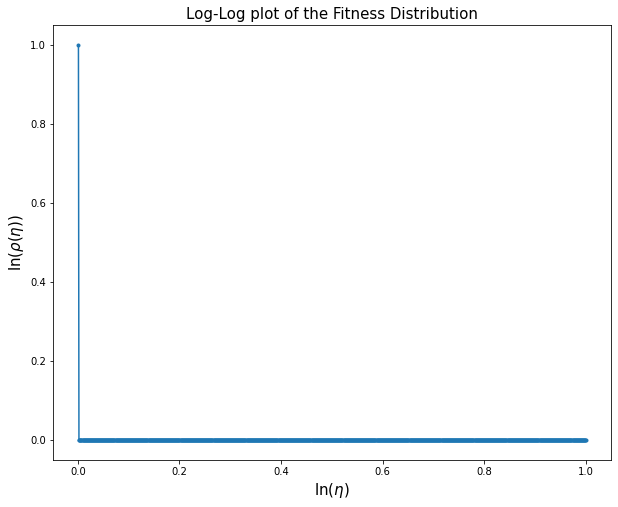

In [39]:
lβ = np.array(list(β_i.values()))
ϱ_η = np.histogram(lβ/max(lβ), bins=1000, normed=True)
plt.figure(figsize=[10,8])
plt.plot(ϱ_η[1][1:], ϱ_η[0]/sum(ϱ_η[0]), '.-')
plt.ylabel(r'$\ln(\rho(\eta))$', fontsize=15)
plt.xlabel(r'$\ln(\eta)$', fontsize=15)
plt.title('Log-Log plot of the Fitness Distribution', fontsize=15)

# Node Growth

In [9]:
TDG = TDiGraph(data)
n_nodes = []
k_max = []
for i in range(len(TDG.time_steps)-1):
    TDG.forward()
    n_nodes.append(TDG.number_of_nodes())
    k_max.append(max(list(TDG.degree()), key=lambda x:x [1])[1])

[Text(0.0, 0, '2005'),
 Text(11.38888888888889, 0, '2006'),
 Text(22.77777777777778, 0, '2007'),
 Text(34.16666666666667, 0, '2008'),
 Text(45.55555555555556, 0, '2009'),
 Text(56.94444444444444, 0, '2010'),
 Text(68.33333333333334, 0, '2011'),
 Text(79.72222222222223, 0, '2012'),
 Text(91.11111111111111, 0, '2013'),
 Text(102.5, 0, '2014'),
 Text(113.88888888888889, 0, '2015'),
 Text(125.27777777777779, 0, '2016'),
 Text(136.66666666666669, 0, '2017'),
 Text(148.05555555555557, 0, '2018'),
 Text(159.44444444444446, 0, '2019'),
 Text(170.83333333333334, 0, '2020'),
 Text(182.22222222222223, 0, '2021'),
 Text(193.61111111111111, 0, '2022')]

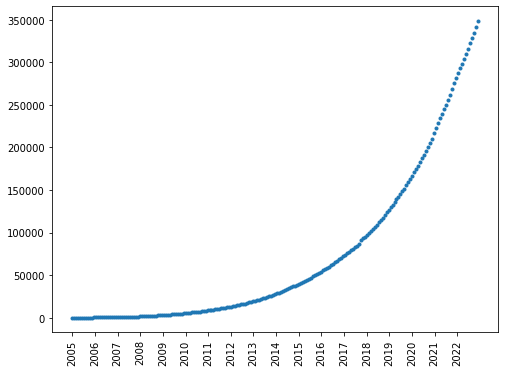

In [10]:
fig, ax = plt.subplots(1, 1, figsize=[8, 6])
ax.plot(n_nodes, '.')
ax.set_xticks([len(n_nodes)/len(years)*i for i in range(len(years))])
ax.set_xticklabels(years, rotation='vertical')

# Preferential Attachment

In [69]:
Π_i = []
deg = []
#α_i = {}
#ᾱ = 0; σ_α = 0
#j = 0
for node, k_i in k_i_t: #for i in range(len(k_i_t)) if max(k_i_t[i][1]) > 10 and len(k_i_t[i][1]) > 10]:
    try:
        #π_k = np.cumsum(np.gradient(k_i, 1))
        #popt, pcov = curve_fit(fit_lin, k_i, π_k)
        #if popt[0] < 0:
        #    continue
        #α_i[node] = popt[0]
        #ᾱ += popt[0] ; σ_α += np.sqrt(pcov[0, 0])
        #j += 1
    except:
        continue
#ᾱ = ᾱ/j; σ_α +=  σ_α/j

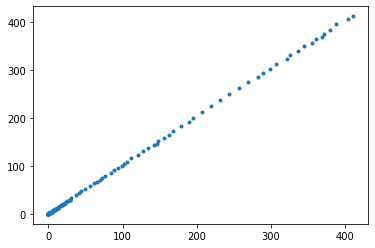

In [114]:
plt.plot(k_i_t[200][1], np.cumsum(np.gradient(k_i_t[200][1])), '.')



In [110]:
?np.cumsum

In [103]:
len(k_i_t[200][1])

124